In [1]:
%matplotlib inline

---
title: Maximum Likelihood Estimation of Custom Models in Python with StatsModels
tags: Statistics, Python
---

Maximum likelihood estimation is a common method for fitting statistical models.  In Python, it is quite possible to fit maximum likelihood models using just [`scipy.optimize`](http://docs.scipy.org/doc/scipy/reference/optimize.html). Over time, however, I have come to prefer the convenience provided by [`statsmodels`'](http://statsmodels.sourceforge.net/) [`GenericLikelihoodModel`](http://statsmodels.sourceforge.net/devel/dev/generated/statsmodels.base.model.GenericLikelihoodModel.html).  In this post, I will show how easy it is to subclass `GenericLikelihoodModel` and take advantage of much of `statsmodels`' well-developed machinery for maximum likelihood estimation of custom models.

#### Zero-inflated Poisson models

The model we use for this demonstration is a [zero-inflated Poisson model](http://en.wikipedia.org/wiki/Zero-inflated_model#Zero-inflated_Poisson).  This is a model for count data that generalizes the Poisson model by allowing for an overabundance of zero observations.

The model has two parameters, $\pi$, the proportion of excess zero observations, and $\lambda$, the mean of the Poisson distribution.  We assume that observations from this model are generated as follows.  First, a weighted coin with probability $\pi$ of landing on heads is flipped.  If the result is heads, the observation is zero.  If the result is tails, the observation is generated from a Poisson distribution with mean $\lambda$.  Note that there are two ways for an observation to be zero under this model:

1. the coin is heads, and
2. the coin is tails, and the sample from the Poisson distribution is zero.

If $X$ has a zero-inflated Poisson distribution with parameters $\pi$ and $\lambda$, its probability mass function is given by

$$\begin{align*}
P(X = 0)
    & = \pi + (1 - \pi)\ e^{-\lambda} \\
P(X = x)
    & = (1 - \pi)\ e^{-\lambda}\ \frac{\lambda^x}{x!} \textrm{ for } x > 0.
\end{align*}$$

In this post, we will use the parameter values $\pi = 0.3$ and $\lambda = 2$.  The probability mass function of the zero-inflated Poisson distribution is shown below, next to a normal Poisson distribution, for comparison.

In [2]:
from __future__ import division

from matplotlib import  pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns
from statsmodels.base.model import GenericLikelihoodModel

In [3]:
np.random.seed(123456789)

In [4]:
pi = 0.3
lambda_ = 2.

In [5]:
def zip_pmf(x, pi=pi, lambda_=lambda_):
    if pi < 0 or pi > 1 or lambda_ <= 0:
        return np.zeros_like(x)
    else:
        return (x == 0) * pi + (1 - pi) * stats.poisson.pmf(x, lambda_)

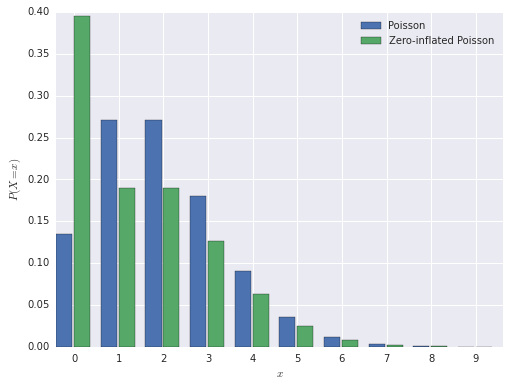

In [6]:
fig, ax = plt.subplots(figsize=(8, 6))

xs = np.arange(0, 10);

palette = sns.color_palette()

ax.bar(2.5 * xs, stats.poisson.pmf(xs, lambda_), width=0.9, color=palette[0], label='Poisson');
ax.bar(2.5 * xs + 1, zip_pmf(xs), width=0.9, color=palette[1], label='Zero-inflated Poisson');

ax.set_xticks(2.5 * xs + 1);
ax.set_xticklabels(xs);
ax.set_xlabel('$x$');

ax.set_ylabel('$P(X = x)$');

ax.legend();

#### Maximum likelihood estimation

First we generate 1,000 observations from the zero-inflated model.

In [7]:
N = 1000

In [8]:
inflated_zero = stats.bernoulli.rvs(pi, size=N)
x = (1 - inflated_zero) * stats.poisson.rvs(lambda_, size=N)

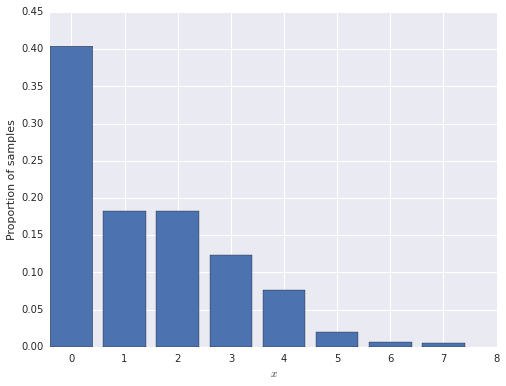

In [9]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.hist(x, width=0.8, bins=np.arange(x.max() + 1), normed=True);

ax.set_xticks(np.arange(x.max() + 1) + 0.4);
ax.set_xticklabels(np.arange(x.max() + 1));
ax.set_xlabel('$x$');

ax.set_ylabel('Proportion of samples');

We are now ready to estimate $\pi$ and $\lambda$ by maximum likelihood.  To do so, we define a class that inherits from `statsmodels`' `GenericLikelihoodModel` as follows.

In [10]:
class ZeroInflatedPoisson(GenericLikelihoodModel):
    def __init__(self, endog, exog=None, **kwds):
        if exog is None:
            exog = np.zeros_like(endog)
            
        super(ZeroInflatedPoisson, self).__init__(endog, exog, **kwds)
    
    def nloglikeobs(self, params):
        pi = params[0]
        lambda_ = params[1]

        return -np.log(zip_pmf(self.endog, pi=pi, lambda_=lambda_))
    
    def fit(self, start_params=None, maxiter=10000, maxfun=5000, **kwds):
        if start_params is None:
            lambda_start = self.endog.mean()
            excess_zeros = (self.endog == 0).mean() - stats.poisson.pmf(0, lambda_start)
            
            start_params = np.array([excess_zeros, lambda_start])
            
        return super(ZeroInflatedPoisson, self).fit(start_params=start_params,
                                                    maxiter=maxiter, maxfun=maxfun, **kwds)

The key component of this class is the method `nloglikeobs`, which returns the negative log likelihood of each observed value in `endog`.  Secondarily, we must also supply reasonable initial guesses of the parameters in `fit`.  Obtaining the maximum likelihood estimate is now simple.

In [11]:
model = ZeroInflatedPoisson(x)
results = model.fit()

Optimization terminated successfully.
         Current function value: 1.586641
         Iterations: 37
         Function evaluations: 70


We see that we have estimated the parameters fairly well.

In [12]:
pi_mle, lambda_mle = results.params

pi_mle, lambda_mle

(0.31542487710071976, 2.0451304204850853)

There are many advantages to buying into the `statsmodels` ecosystem and subclassing `GenericLikelihoodModel`.  The already-written `statsmodels` code handles storing the observations and the interaction with `scipy.optimize` for us.  (It is possible to control the use of `scipy.optimize` through keyword arguments to `fit`.)

We also gain access to many of `statsmodels`' built in model analysis tools.  For example, we can use bootstrap resampling to estimate the variation in our parameter estimates.

In [13]:
boot_mean, boot_std, boot_samples = results.bootstrap(nrep=500, store=True)
boot_pis = boot_samples[:, 0]
boot_lambdas = boot_samples[:, 1]

<class '__main__.ZeroInflatedPoisson'>


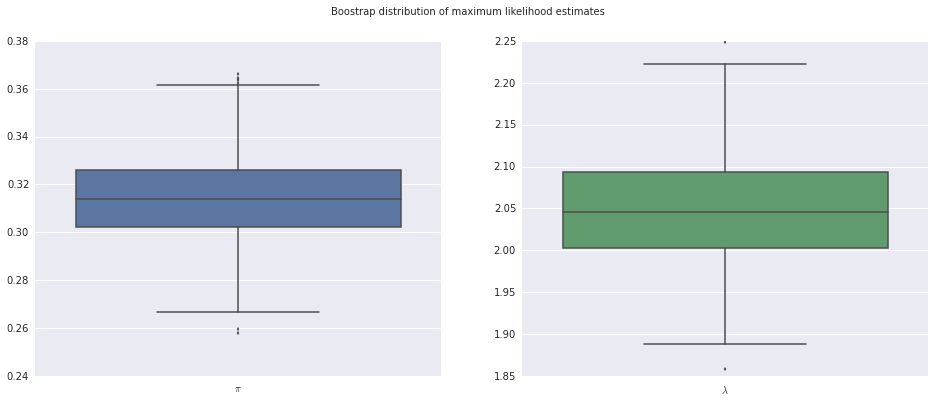

In [14]:
fig, (pi_ax, lambda_ax) = plt.subplots(ncols=2, figsize=(16, 6))

sns.boxplot(boot_pis, ax=pi_ax, names=['$\pi$'], color=palette[0]);
sns.boxplot(boot_lambdas, ax=lambda_ax, names=['$\lambda$'], color=palette[1]);

fig.suptitle('Boostrap distribution of maximum likelihood estimates');

The next time you are fitting a model using maximum likelihood, try integrating with `statsmodels` to take advantage of the significant amount of work that has gone into its ecosystem.